In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import plotly.express as px

In [2]:
from reward_function import Utils, SpeedUtils, Path, reward_function

In [3]:
# def smoothen(waypoints):
#     optimumpointlist = []
#     i = 0
#     range_factor = 6
#     avg_factor = 2 * range_factor + 1
#     num_of_waypoints = len(waypoints)

#     for point in waypoints:
#         counter = 0
#         estimated_x_cord = point[0]
#         estimated_y_cord = point[1]
#         while counter < range_factor:
#             estimated_x_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][0]
#             estimated_x_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][0]

#             estimated_y_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][1]
#             estimated_y_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][1]
#             counter += 1

#         estimated_x_cord = estimated_x_cord / avg_factor
#         estimated_y_cord = estimated_y_cord / avg_factor


#         optimumpointlist.append(np.array( (estimated_x_cord, estimated_y_cord) ))

#         i += 1
#     return np.array(optimumpointlist)

In [4]:
# def calc_distance(prev_point, next_point):
#     delta_x = next_point[0] - prev_point[0]
#     delta_y = next_point[1] - prev_point[1]
#     return math.hypot(delta_x, delta_y)

# def smooth_central_line(center_line, max_offset, pp=0.10, p=0.05, c=0.70, n=0.05, nn=0.10, iterations=72, skip_step=1):
#     if max_offset < 0.0001:
#         return center_line
#     if skip_step < 1:
#         skip_step = 1
#     smoothed_line = center_line
#     for i in range(0, iterations):
#         smoothed_line = smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step)
#     return smoothed_line


# def smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step):
#     length = len(center_line)
#     new_line = [[0.0 for _ in range(2)] for _ in range(length)]
#     for i in range(0, length):
#         wpp = smoothed_line[(i - 2 * skip_step + length) % length]
#         wp = smoothed_line[(i - skip_step + length) % length]
#         wc = smoothed_line[i]
#         wn = smoothed_line[(i + skip_step) % length]
#         wnn = smoothed_line[(i + 2 * skip_step) % length]
#         new_line[i][0] = pp * wpp[0] + p * wp[0] + c * wc[0] + n * wn[0] + nn * wnn[0]
#         new_line[i][1] = pp * wpp[1] + p * wp[1] + c * wc[1] + n * wn[1] + nn * wnn[1]
#         while calc_distance(new_line[i], center_line[i]) >= max_offset:
#             new_line[i][0] = (0.98 * new_line[i][0]) + (0.02 * center_line[i][0])
#             new_line[i][1] = (0.98 * new_line[i][1]) + (0.02 * center_line[i][1])
#     return new_line

In [5]:
TRACK_NAME = 'C:/Users/suraj/projects/deepracer24/FS_June2020.npy'

# Load the center, inner, outer waypoints
waypoints = np.load(TRACK_NAME)

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

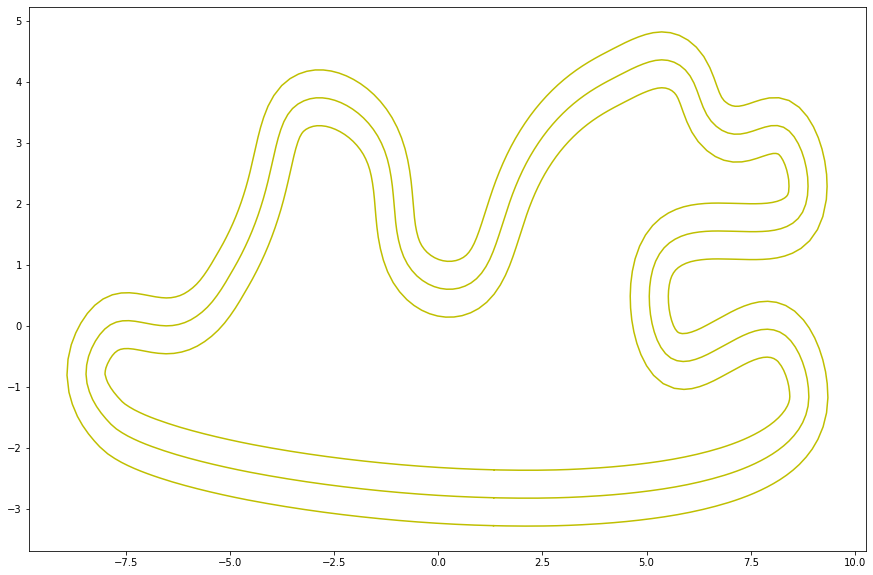

In [6]:
plt.plot(center_line[:,0], center_line[:,1], label = 'outer_border', c = 'y')
plt.plot(inner_border[:,0], inner_border[:,1], label = 'outer_border', c = 'y')
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'y')
plt.show()

In [7]:
len(center_line)

354

In [8]:
path_object = Path( center_line, 0 )
smooth_path = path_object.get()
smooth_path = np.array( [ np.array(point) for point in smooth_path ] )
print(len(smooth_path))

calculating smooth path
354


In [9]:
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r

def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]

def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead

In [10]:
def getEverything(racing_track, velocity):

    def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

    distance_to_prev = []
    for i in range(len(racing_track)):
        indexes = SpeedUtils.circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
        coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
        dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
        distance_to_prev.append(dist_to_prev)
        
    time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

    total_time = sum(time_to_prev)
    print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

In [11]:
MIN_SPEED = 1.1
MAX_SPEED = 5.5
LOOK_AHEAD = 8
useCache = False
optimal_velocity_ =  SpeedUtils.optimal_velocity(smooth_path, MIN_SPEED, MAX_SPEED, LOOK_AHEAD, useCache=useCache)

In [12]:
import pandas as pd

data = pd.read_csv('C:/Users/suraj/projects/deepracer24/deepracer-log-guru/logs/033/training_data.csv')
status_col = 'episode_status' if 'episode_status' in data.columns else 'status'
data = data[data[status_col].isin(['in_progress', 'on_track'])]
data.rename(columns={'X':'x', 'Y':'y', 'yaw':'heading', 'steer':'steering_angle', 'throttle':'speed', 'closest_waypoint': 'closest_waypoints'}, inplace=True)
data['is_offtrack'] = ~data['on_track']
data['all_wheels_on_track'] = data['on_track']
data['distance_from_center'] = 0.1
data['is_left_of_center'] = False
data['is_crashed'] = False
data = data[['x', 'y', 'heading', 'speed', 'steering_angle', 'progress', 'is_left_of_center', 'closest_waypoints', 'steps', 'is_offtrack', 'is_crashed', 'all_wheels_on_track', 'distance_from_center']]
data.shape

(33717, 13)

In [13]:
# data = data[data['is_offtrack']==True]
data.shape

(33717, 13)

In [14]:
def get_params(row_number):
    params = data.iloc[row_number].to_dict()
    params['closest_waypoints'] = [ params['closest_waypoints'], params['closest_waypoints']+1 ]
    # print(params)

    params['waypoints'] = list( [list(point) for point in center_line] )
    params['track_width'] = 1.07
    params['is_reversed'] = False

    return params

In [15]:
params = get_params(805)
print(params)
print( reward_function( params ) )

{'x': 0.7353, 'y': 5.3888, 'heading': 172.424, 'speed': 2.5, 'steering_angle': 0, 'progress': 2.2663, 'is_left_of_center': False, 'closest_waypoints': [28, 29], 'steps': 7, 'is_offtrack': False, 'is_crashed': False, 'all_wheels_on_track': True, 'distance_from_center': 0.1, 'waypoints': [[1.3333835005760193, -2.8131200075149536], [1.183136522769928, -2.8104419708251953], [1.0328985452651978, -2.8073339462280273], [0.8826694488525391, -2.8037965297698975], [0.7324512302875519, -2.7998324632644653], [0.5822446346282959, -2.795442581176758], [0.43205125629901886, -2.790626049041748], [0.28187204897403717, -2.7853859663009644], [0.1317080482840538, -2.7797240018844604], [-0.018439327308443748, -2.773640990257263], [-0.16856930404901505, -2.7671384811401367], [-0.3186803460121155, -2.7602174282073975], [-0.4687718003988266, -2.752879023551941], [-0.6188421547412863, -2.7451255321502686], [-0.7688906490802765, -2.736956477165222], [-0.918916046619416, -2.7283765077590942], [-1.068917512893676

In [19]:
plotData = pd.DataFrame( {'x': smooth_path[:,0], 'y': smooth_path[:,1], 'speed': optimal_velocity_} )
fig = px.scatter(data_frame=plotData, x = 'x', y = 'y', color='speed', hover_data='speed')
_ = getEverything(smooth_path, optimal_velocity_)
fig.show()

Total time for track, if racing line and speeds are followed perfectly: 16.917773803335177 s


In [20]:
# plt.plot(center_line[:,0], center_line[:,1], label = 'outer_border', c = 'y')
# plt.plot(inner_border[:,0], inner_border[:,1], label = 'outer_border', c = 'y')
# plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'y')
# plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'outer_border', c = 'k')
# for i, point in enumerate(smooth_path):
#     point = list(point)        
#     try:
#         plt.scatter(point[0], point[1], s = optimal_velocity_[i]**3, c = 'k' if optimal_velocity_[i]<2 else 'r')
#     except:
#         print(point)

# plt.show()

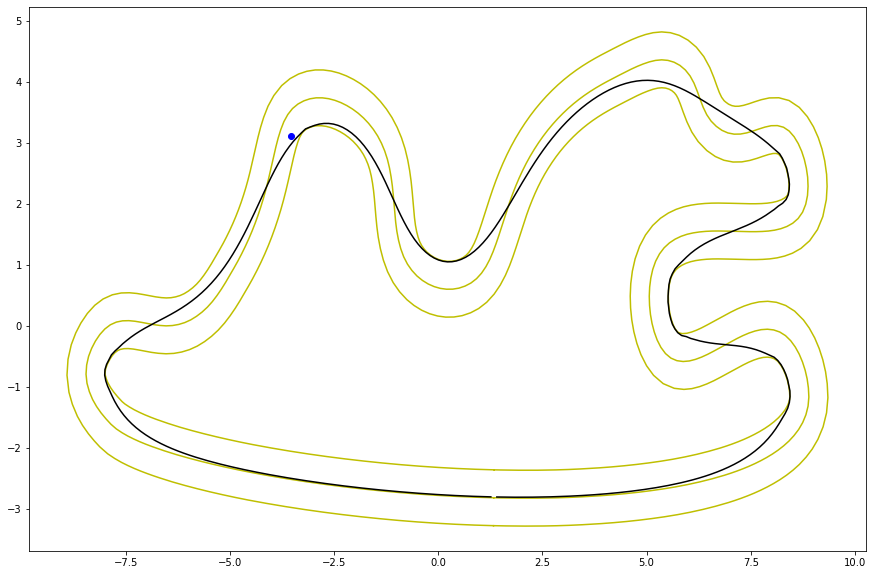

In [21]:
target = [-3.52613775941606, 3.108002357052378]
params['x'] = target[0]
params['y'] = target[1]
params['steering_angle'] = 0.52
params['heading'] = 20
params['speed'] = 1.5
plt.scatter(params['x'], params['y'], c = 'b')


plt.plot(center_line[:,0], center_line[:,1], label = 'outer_border', c = 'y')
plt.plot(inner_border[:,0], inner_border[:,1], label = 'outer_border', c = 'y')
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'y')
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'outer_border', c = 'k')
# for i, point in enumerate(smooth_path):
#     point = list(point)        
#     plt.scatter(point[0], point[1], s = optimal_velocity_[i]*10, c = 'k' if optimal_velocity_[i]<2 else 'r')

# plt.scatter(target[0], target[1], c = 'g', s = 5)

plt.show()


In [19]:
reward_function(params)

34.62571428571429

In [20]:
rewards = []
for i in random.sample(range(0, len(data)), 500):
    params = get_params(i)
    rewards.append( reward_function( params ) )
    if i%50 == 0:
        print(i, ' rows done')
rewards_df = pd.DataFrame({'rewards':rewards})
rewards_df.describe()

11250  rows done
18950  rows done
31850  rows done
27400  rows done
5850  rows done
1750  rows done
31700  rows done


,rewards
count,500.000000
mean,42.880648
std,16.032478
min,12.210000
25%,28.045357
50%,44.886750
75%,54.965744
max,84.881111


In [24]:
import matplotlib.pyplot as plt
steering_reward = lambda x: max(1e-3, (0.5 - abs(x)/30.0))*2
speed_reward    = lambda x: max(1e-3, 0.5 - abs(x)/(4.0-1.25))*2
ontrack_reward  = lambda x: max(1e-3, 0.5 - (2*abs(x)/(1.07)))*2
total_reward    = lambda x: steering_reward(x) + speed_reward(x) + ontrack_reward(x)
y = ontrack_reward

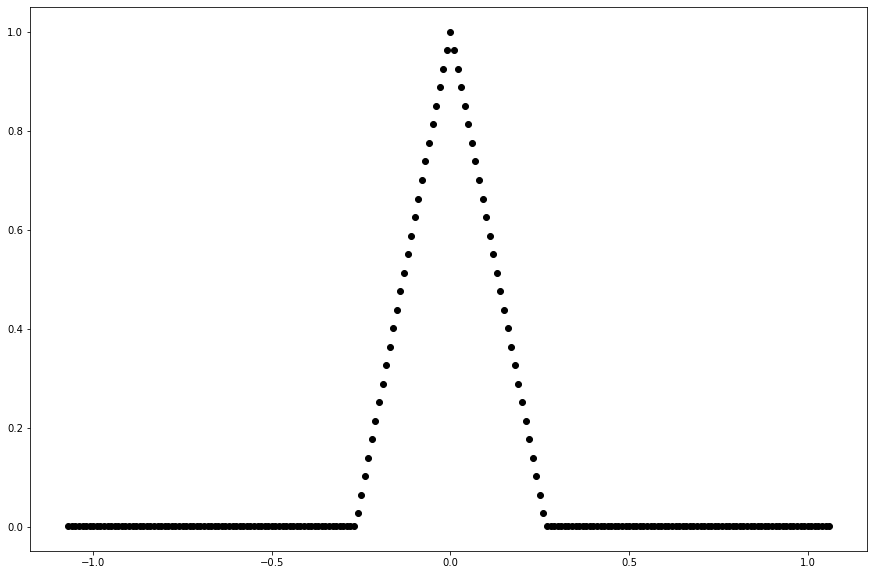

In [26]:
for i in range(-107, 107):
    x = i/100
    plt.scatter(x, y(x),c='k')
plt.show()

In [ ]:
optimal_speed_penalty = lambda diff, optimal_speed: max(0, 1 - abs(diff) / optimal_speed)

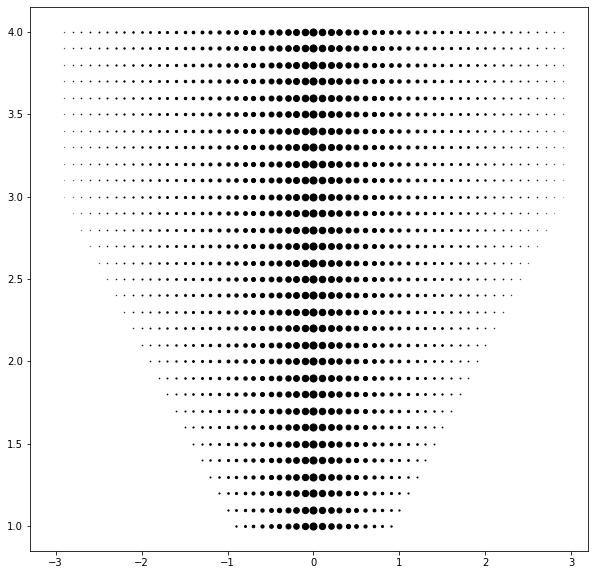

In [ ]:
for diff in range(-30, 30):
    diff = diff/10
    for optimal_velocity in range(10, 41):
        optimal_velocity = optimal_velocity/10
        penalty = optimal_speed_penalty(diff, optimal_velocity)
        
        reward = y(diff) * penalty
        plt.scatter(diff, optimal_velocity, s = reward*50 , c = 'k')
plt.show()

In [ ]:
sp = Path(center_line).get()

In [ ]:
closest = Path(center_line).closest((params['x'], params['y']), 2)
prev = closest[0]
nex = closest[1]

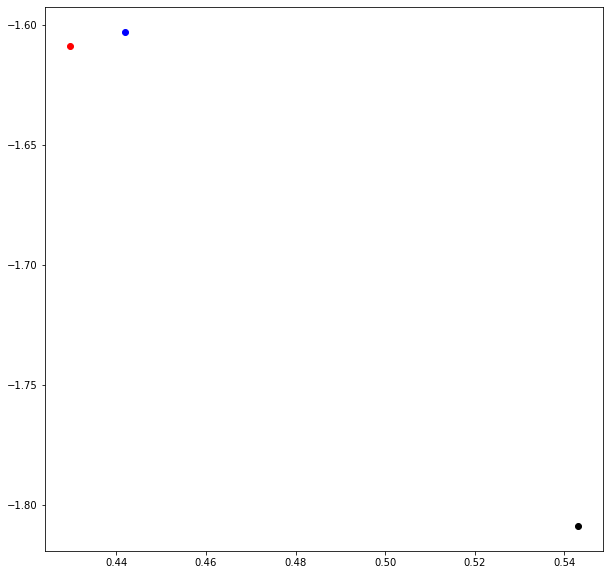

In [ ]:
plt.scatter(params['x'], params['y'], c = 'k')
plt.scatter(prev[0], prev[1], c = 'b')
plt.scatter(nex[0], nex[1], c = 'r')
plt.show()

In [ ]:
Utils.distanceFromLine(prev, nex, (params['x'], params['y']))

0.22943080917732178

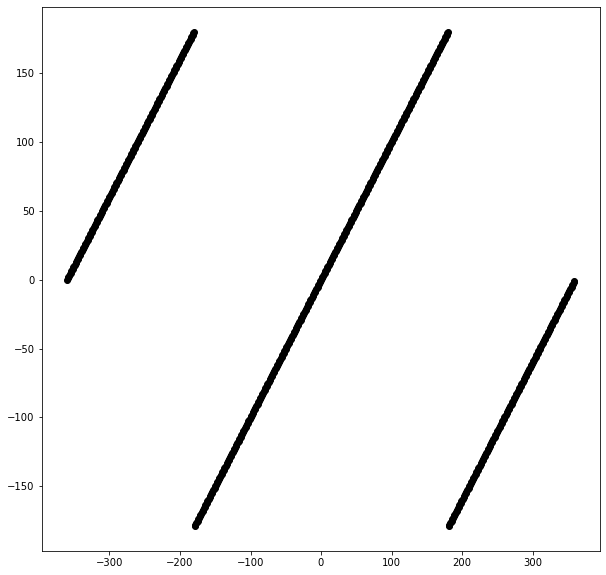

In [ ]:
for angle in range(-360, 360):
    plt.scatter(angle, Utils.normalize_angle(angle), c = 'k')
plt.show()

In [ ]:
from reward_function import Utils

Utils.normalize_angle( Utils.angle_between_points( (1, 1), (0, 0) ) - 135 ) - -45

135.0

In [ ]:
dist = 0
prev_point = center_line[0]
for point in center_line[1:]:
    dist += Utils.distance( prev_point, point )
    prev_point = point
dist

42.1918841751529

In [ ]:
0.999**1000 - 0.3586

0.009095424770963756

In [53]:
import matplotlib.pyplot as plt

In [54]:
y = lambda factor, steps: max( factor**steps - 0.3586, 0 )

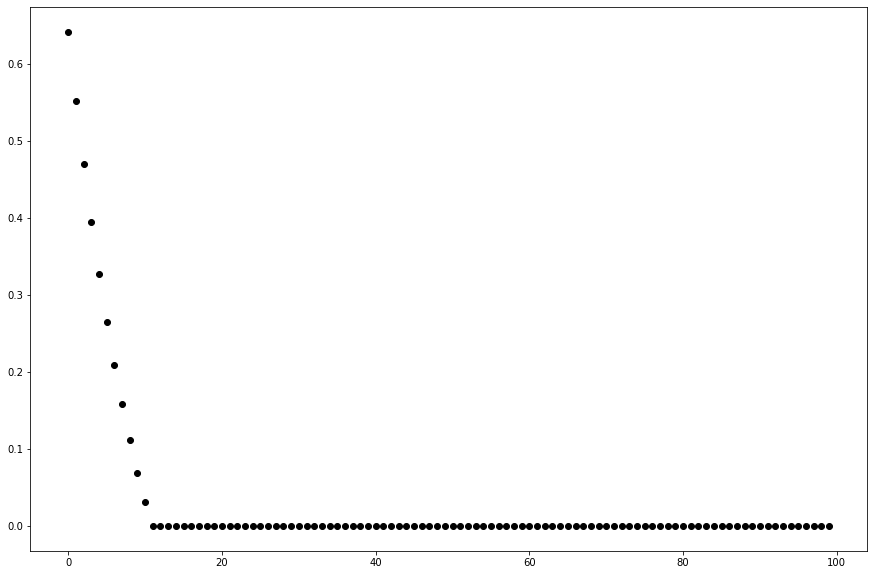

11


In [55]:
factor = 0.91
x = [i for i in range(100)]
ans = [y(factor, i) for i in x]
plt.scatter(x, ans, c = 'k')
plt.show()

for x, a in zip(x, ans):
    if a<=0:
        print(x)
        break


In [ ]:
34/len(center_line)

0.096045197740113